In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('/kaggle/input/onion-csv/onion_price_2012_to_2024_cleaned.csv')

In [4]:
df['Min Price (Rs./Quintal)'] = df['Min Price (Rs./Quintal)'].fillna(df['Min Price (Rs./Quintal)'].mean())
df['Max Price (Rs./Quintal)'] = df['Max Price (Rs./Quintal)'].fillna(df['Max Price (Rs./Quintal)'].mean())
df['Modal Price (Rs./Quintal)'] = df['Modal Price (Rs./Quintal)'].fillna(df['Modal Price (Rs./Quintal)'].mean())
df = df.drop(columns=['Variety', 'Grade', 'Sl no.'])

# Convert 'Price Date' to datetime
df['Price Date'] = pd.to_datetime(df['Price Date'], errors='coerce')
df.dropna(subset=['Price Date'], inplace=True)

# Extract Year, Month, Day
df['Year'] = df['Price Date'].dt.year
df['Month'] = df['Price Date'].dt.month
df['Day'] = df['Price Date'].dt.day

df.head()

,District Name,Market Name,Commodity,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,Year,Month,Day
0,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-01-02,2012,1,2
1,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-05-07,2012,5,7
2,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-05-11,2012,5,11
3,Fazilka,Abohar,Onion,500.0,800.0,700.0,2012-08-07,2012,8,7
4,Fazilka,Abohar,Onion,500.0,800.0,700.0,2012-07-26,2012,7,26


In [5]:
df.isnull().sum()

District Name                0
Market Name                  0
Commodity                    0
Min Price (Rs./Quintal)      0
Max Price (Rs./Quintal)      0
Modal Price (Rs./Quintal)    0
Price Date                   0
Year                         0
Month                        0
Day                          0
dtype: int64

In [6]:
# Calculate average price
df['Average Price'] = (df['Min Price (Rs./Quintal)'] + df['Max Price (Rs./Quintal)'] + df['Modal Price (Rs./Quintal)']) / 3

# Categorize the average price into 'Low', 'Mid', 'High'
df['Price Category'] = pd.cut(df['Average Price'], bins=[0, 1000, 2000, float('inf')], labels=['Low', 'Mid', 'High'])


In [7]:
df.head()

,District Name,Market Name,Commodity,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date,Year,Month,Day,Average Price,Price Category
0,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-01-02,2012,1,2,533.333333,Low
1,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-05-07,2012,5,7,533.333333,Low
2,Fazilka,Abohar,Onion,450.0,650.0,500.0,2012-05-11,2012,5,11,533.333333,Low
3,Fazilka,Abohar,Onion,500.0,800.0,700.0,2012-08-07,2012,8,7,666.666667,Low
4,Fazilka,Abohar,Onion,500.0,800.0,700.0,2012-07-26,2012,7,26,666.666667,Low


In [10]:
from sklearn.preprocessing import StandardScaler
# Features and Target
X = df[['Year', 'Month', 'Day']]
y = df['Price Category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

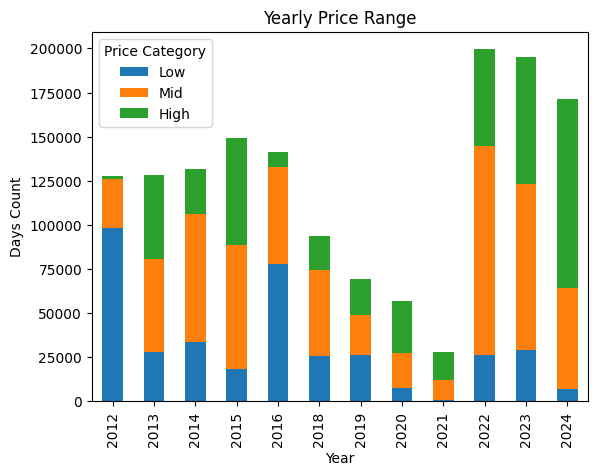

In [11]:
# 1. Yearly price range
df['Year'] = pd.to_datetime(df[['Year', 'Month', 'Day']]).dt.year
# Explicitly setting observed=False to match the current behavior
price_categories = df.groupby(['Year', 'Price Category'], observed=False).size().unstack(fill_value=0)
price_categories.plot(kind='bar', stacked=True)
plt.title('Yearly Price Range')
plt.xlabel('Year')
plt.ylabel('Days Count')
plt.show()


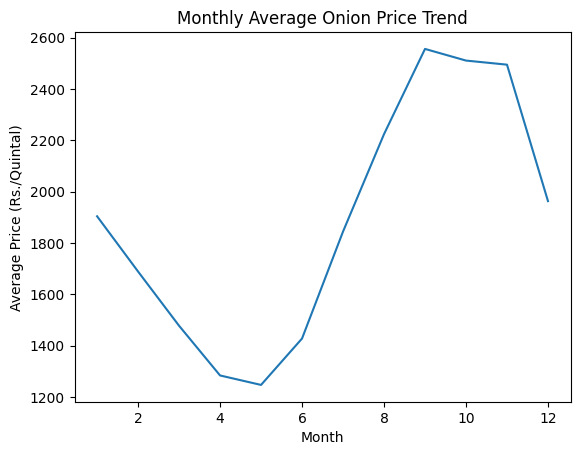

In [12]:
# 2. Monthly price trend
monthly_avg = df.groupby('Month', observed=False)['Average Price'].mean()
plt.plot(monthly_avg)
plt.title('Monthly Average Onion Price Trend')
plt.xlabel('Month')
plt.ylabel('Average Price (Rs./Quintal)')
plt.show()

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

In [16]:
# Extra: LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshape data for LSTM
X_lstm = df[['Average Price']].values
scaler_lstm = StandardScaler()
X_lstm = scaler_lstm.fit_transform(X_lstm)

# Create dataset for LSTM
def create_dataset(X, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step - 1):
        Xs.append(X[i:(i + time_step), 0])
        ys.append(X[i + time_step, 0])
    return np.array(Xs), np.array(ys)

time_step = 10
X_lstm, y_lstm = create_dataset(X_lstm, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

# Split data
train_size = int(len(X_lstm) * 0.7)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]


In [ ]:
# Train LSTM Model
lstm_model = create_lstm_model((X_train_lstm.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=1, verbose=1)
lstm_predictions = lstm_model.predict(X_test_lstm)

In [ ]:
# 3. Actual vs Predicted Prices (LSTM)
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm, label='Actual Prices', color='red')
plt.plot(lstm_predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Onion Prices (LSTM)')
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()


Why Use Machine Learning Models Like SVM, Decision Tree for Time Series Data?
The use of classification models like SVM, Decision Trees, and Naive Bayes in time series datasets can still be beneficial for certain specific tasks:

Classification of Price Categories:
Instead of predicting the exact future price, the task might be to classify the price into categories such as "Low," "Medium," or "High." This is a classification problem where machine learning models like Decision Trees, SVM, or KNN are suitable.
For instance, if the goal is to help stakeholders (like farmers or traders) decide whether the current market price is "Low," "Medium," or "High" based on historical patterns, classification models can serve this purpose.

Hybrid Modeling:
In practice, hybrid approaches can be used where machine learning classification models complement time series models. For example:
A time series model like LSTM might predict the future price.
A classification model can then categorize the predicted value into "High," "Medium," or "Low."

Market Condition Prediction:
Sometimes, the goal is not to predict exact prices but to predict market conditions (e.g., high volatility, price drop). Here, classification models can be useful.